# Data

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../full_portfolio_analysis.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:

from backbone.utils.wfo_utils import run_strategy, run_wfo
from backbone.utils.general_purpose import calculate_units_size, diff_pips

import itertools
import numpy as np
import pandas as pd
import pandas_ta as pandas_ta
import MetaTrader5 as mt5
import pandas as pd
from backtest.get_data import get_data
import pytz
from datetime import datetime
from pandas import Timestamp
import numpy as np
import random
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random.seed(42)

In [3]:
INITIAL_CASH = 10_000
MARGIN = 1/30
COMMISSION = 0.0005

timezone = pytz.timezone("Etc/UTC")
date_from_get_data = datetime(2021, 10, 1, tzinfo=timezone)
date_to_get_data = datetime(2024, 9, 1, tzinfo=timezone)

#
limited_testing_start_date = Timestamp('2019-01-01 00:00:00', tz='UTC')
limited_testing_end_date = Timestamp('2024-10-01 00:00:00', tz='UTC')

In [4]:
groups = [
    'Forex',
    'Cash CFD',
    'Cash II CFD',
    'Metals CFD',
    'Crypto CFD',
    'Exotics',
    'Equities I CFD',
    'Equities II CFD',
    'Agriculture',
    'Commodities'
]

In [5]:
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

symbols = mt5.symbols_get()

tickers = [symbol.path.split('\\')[1] for symbol in symbols if (
    ('Agriculture' in symbol.path)
    or ('Cash CFD' in symbol.path)
    or ('Cash II CFD' in symbol.path)
    or ('Crypto CFD' in symbol.path)
    or ('Equities I CFD' in symbol.path)
    or ('Equities II CFD' in symbol.path)
    or ('Agriculture' in symbol.path)
    or ('Equities II CFD' in symbol.path)
    or ('Commodities' in symbol.path)
    or ('Forex' in symbol.path)
    )
]

print(tickers)

intervals = [
    # mt5.TIMEFRAME_H8,
    # mt5.TIMEFRAME_H6,
    mt5.TIMEFRAME_H4,
    mt5.TIMEFRAME_H3,
    mt5.TIMEFRAME_H2,
    mt5.TIMEFRAME_H1,
    mt5.TIMEFRAME_M15,
]

symbols = get_data(tickers, intervals, date_from_get_data, date_to_get_data)

['EURUSD', 'GBPUSD', 'USDCHF', 'USDJPY', 'USDCAD', 'AUDUSD', 'AUDNZD', 'AUDCAD', 'AUDCHF', 'AUDJPY', 'CHFJPY', 'EURGBP', 'EURAUD', 'EURCHF', 'EURJPY', 'EURNZD', 'EURCAD', 'GBPCHF', 'GBPJPY', 'CADCHF', 'CADJPY', 'GBPAUD', 'GBPCAD', 'GBPNZD', 'NZDCAD', 'NZDCHF', 'NZDJPY', 'NZDUSD', 'GER40.cash', 'UK100.cash', 'US100.cash', 'US30.cash', 'US500.cash', 'AUS200.cash', 'EU50.cash', 'FRA40.cash', 'HK50.cash', 'JP225.cash', 'SPN35.cash', 'US2000.cash', 'N25.cash', 'UKOIL.cash', 'USOIL.cash', 'ADAUSD', 'BTCUSD', 'DASHUSD', 'DOGEUSD', 'DOTUSD', 'ETHUSD', 'LTCUSD', 'NEOUSD', 'XMRUSD', 'XRPUSD', 'AAPL', 'AMZN', 'BABA', 'BAC', 'GOOG', 'META', 'MSFT', 'NFLX', 'NVDA', 'PFE', 'RACE', 'T', 'TSLA', 'V', 'WMT', 'ZM', 'AIRF', 'ALVG', 'BAYGn', 'DBKGn', 'IBE', 'LVMH', 'VOWG_p', 'COCOA.c', 'COFFEE.c', 'CORN.c', 'SOYBEAN.c', 'WHEAT.c', 'NATGAS.cash']
MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
EURUSD
EURUSD
EURUSD
EURUSD
EURUSD
GBPUSD
GBPUSD
GBPUSD
GBPUSD
GBPUSD
USDCHF
U

KeyboardInterrupt: 

In [21]:
max_start_date = None
intervals_start_dates = {}

tickers = np.unique(list(symbols.keys())).tolist()

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date


print(intervals_start_dates)
print(limited_testing_start_date)
print(limited_testing_end_date)

{16388: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16387: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16386: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16385: Timestamp('2024-10-23 01:00:00+0000', tz='UTC'), 15: Timestamp('2024-10-23 01:00:00+0000', tz='UTC')}
2019-01-01 00:00:00+00:00
2024-10-01 00:00:00+00:00


In [ ]:

from backbone.triple_supertrend import TripleSuperTrend

STRATEGY = TripleSuperTrend

# Analisis preliminar

In [23]:
strategies = [
    STRATEGY
]

experiments = list(itertools.product(
    tickers, intervals, strategies
))

stats_per_symbol = {}

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:
    try:
        print(ticker, interval)
        
        if ticker not in stats_per_symbol.keys():
            stats_per_symbol[ticker] = {}
        
        prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

        df_stats, stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN
        )

        performance = pd.concat([performance, df_stats])
        stats_per_symbol[ticker][interval] = stats

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)

AAPL 16388
AAPL 16387
AAPL 16386
AAPL 16385
AAPL 15
ADAUSD 16388
ADAUSD 16387
ADAUSD 16386
ADAUSD 16385
ADAUSD 15
AIRF 16388
AIRF 16387
AIRF 16386
AIRF 16385
AIRF 15
ALVG 16388
ALVG 16387
ALVG 16386
ALVG 16385
ALVG 15
AMZN 16388
AMZN 16387
AMZN 16386
AMZN 16385
AMZN 15
AUDCAD 16388
AUDCAD 16387
AUDCAD 16386
AUDCAD 16385
AUDCAD 15
AUDCHF 16388
AUDCHF 16387
AUDCHF 16386
AUDCHF 16385
AUDCHF 15
AUDJPY 16388
AUDJPY 16387
AUDJPY 16386
AUDJPY 16385
AUDJPY 15
AUDNZD 16388
AUDNZD 16387
AUDNZD 16386
AUDNZD 16385
AUDNZD 15
AUDUSD 16388
AUDUSD 16387
AUDUSD 16386
AUDUSD 16385
AUDUSD 15
AUS200.cash 16388
AUS200.cash 16387
AUS200.cash 16386
AUS200.cash 16385
AUS200.cash 15
BABA 16388
BABA 16387
BABA 16386
BABA 16385
BABA 15
BAC 16388
BAC 16387
BAC 16386
BAC 16385
BAC 15
BAYGn 16388
BAYGn 16387
BAYGn 16386
BAYGn 16385
BAYGn 15
BTCUSD 16388
BTCUSD 16387
BTCUSD 16386
BTCUSD 16385
BTCUSD 15
CADCHF 16388
CADCHF 16387
CADCHF 16386
CADCHF 16385
CADCHF 15
CADJPY 16388
CADJPY 16387
CADJPY 16386
CADJPY 16385
C

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


COCOA.c 16386
COCOA.c 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


COCOA.c 15


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


COFFEE.c 16388
COFFEE.c 16387
COFFEE.c 16386
COFFEE.c 16385
COFFEE.c 15
CORN.c 16388
CORN.c 16387
CORN.c 16386
CORN.c 16385
CORN.c 15
DASHUSD 16388
DASHUSD 16387
DASHUSD 16386
DASHUSD 16385
DASHUSD 15
DBKGn 16388
DBKGn 16387
DBKGn 16386
DBKGn 16385
DBKGn 15
DOGEUSD 16388
DOGEUSD 16387
DOGEUSD 16386
DOGEUSD 16385
DOGEUSD 15
DOTUSD 16388
DOTUSD 16387
DOTUSD 16386
DOTUSD 16385
DOTUSD 15
ETHUSD 16388
ETHUSD 16387
ETHUSD 16386
ETHUSD 16385
ETHUSD 15
EU50.cash 16388
EU50.cash 16387
EU50.cash 16386
EU50.cash 16385
EU50.cash 15
EURAUD 16388
EURAUD 16387
EURAUD 16386
EURAUD 16385
EURAUD 15
EURCAD 16388
EURCAD 16387
EURCAD 16386
EURCAD 16385
EURCAD 15
EURCHF 16388
EURCHF 16387
EURCHF 16386
EURCHF 16385
EURCHF 15
EURGBP 16388
EURGBP 16387
EURGBP 16386
EURGBP 16385
EURGBP 15
EURJPY 16388
EURJPY 16387
EURJPY 16386
EURJPY 16385
EURJPY 15
EURNZD 16388
EURNZD 16387
EURNZD 16386
EURNZD 16385
EURNZD 15
EURUSD 16388
EURUSD 16387
EURUSD 16386
EURUSD 16385
EURUSD 15
FRA40.cash 16388
FRA40.cash 16387
FRA40.

In [34]:

rob_test = pd.DataFrame(performance.groupby(['strategy','ticker']).agg({'return/dd':'mean', 'trades':'mean'})).sort_values(by='return/dd', ascending=False)

rob_test = rob_test[(rob_test['return/dd'] > 1) & (rob_test['trades'] > 10)]

display(rob_test)

average_positive_tickers = rob_test.reset_index().ticker.tolist()

filter_performance = performance[performance['ticker'].isin(average_positive_tickers)]

portfolio = filter_performance.ticker.values.tolist()

intervals = filter_performance.interval.values.tolist()

filter_performance = filter_performance.sort_values(by=['ticker', 'interval'], ascending=[True, True])[
    [
        'strategy',
        'ticker',
        'interval',
        'stability_ratio',
        'trades',
        'return',
        'drawdown',
        'return/dd',
        'custom_metric',
        'win_rate',
        'avg_trade_percent',
        'Duration'
        ]
]#.drop_duplicates(subset=['ticker'], keep='first')

display(filter_performance.head(50))

return/dd  trades
strategy         ticker                   
TripleSuperTrend TSLA     2.514166   390.2
                 NVDA     1.140462   407.8

,strategy,ticker,interval,stability_ratio,trades,return,drawdown,return/dd,custom_metric,win_rate,avg_trade_percent,Duration
0,TripleSuperTrend,NVDA,15,0.824019,1215,-56.635794,68.991598,-0.820909,-5.747865,31.111111,-0.079871,1064 days 06:15:00
0,TripleSuperTrend,NVDA,16385,0.205922,353,12.847767,37.223601,0.345151,1.972796,39.376771,0.030379,1064 days 06:00:00
0,TripleSuperTrend,NVDA,16386,0.028253,215,24.832335,19.383998,1.281074,6.548309,38.604651,0.012995,1064 days 06:00:00
0,TripleSuperTrend,NVDA,16387,0.035800,155,22.748075,17.509530,1.299182,6.206235,41.935484,-0.016482,1064 days 06:00:00
0,TripleSuperTrend,NVDA,16388,0.637106,101,30.714377,8.536959,3.597812,14.895016,36.633663,0.388319,1064 days 04:00:00
0,TripleSuperTrend,TSLA,15,0.701260,1156,-44.029052,68.271894,-0.644907,-4.483242,34.083045,-0.058111,1064 days 06:15:00
0,TripleSuperTrend,TSLA,16385,0.144994,344,22.473382,27.214722,0.825780,4.654457,34.011628,0.018109,1064 days 06:00:00
0,TripleSuperTrend,TSLA,16386,0.526822,207,28.241007,13.657474,2.067806,10.283999,33.333333,0.123286,1064 days 06:00:00
0,TripleSuperTrend,TSLA,16387,0.860508,141,60.664489,11.130515,5.450286,24.784002,37.588652,0.913891,1064 days 06:00:00
0,TripleSuperTrend,TSLA,16388,0.877824,103,45.473184,9.333830,4.871868,20.437267,36.893204,0.859110,1064 days 04:00:00


In [27]:
for ticker, interval in zip(portfolio, intervals):
    
    prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

    df_stats = run_strategy(
        strategy=strategy,
        ticker=ticker,
        interval=interval,
        commission=COMMISSION, 
        prices=prices, 
        initial_cash=INITIAL_CASH, 
        margin=MARGIN,
        plot=True
    )
    # break
    

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarn

# WFO

In [17]:
lookback_bars_per_interval = {
    15: 2000,
    16385: 2000,
    16386: 1800,
    16387: 1800,
    16388: 1200,
    16390: 1200,
    16392: 1200,
}

In [ ]:
from backbone.utils.wfo_utils import optimization_function

validation_bars = 200
warmup_bars =  12

all_wfo_performances = pd.DataFrame()
all_opt_params = {}

params = {
    'super_trend_to_use': [
        'supertrend_signal_73',
        'supertrend_signal_123',
        'supertrend_signal_101',
        'supertrend_signal_112',
    ]
}

for index, row in filter_performance.iterrows():
    
    try:
        ticker = row.ticker
        interval = row.interval
        print(ticker, interval)
        
        lookback_bars = lookback_bars_per_interval[interval]
        
        prices = symbols[ticker][interval]

        wfo_stats, df_stats, opt_params = run_wfo(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            prices=prices,
            initial_cash=INITIAL_CASH,
            commission=COMMISSION,
            margin=MARGIN,
            optim_func=optimization_function,
            params=params,
            lookback_bars=lookback_bars,
            warmup_bars=warmup_bars,
            validation_bars=validation_bars,
            plot=False
        )
                
        if ticker not in all_opt_params.keys():
            all_opt_params[ticker] = {}

        all_opt_params[ticker][interval] = opt_params

        all_wfo_performances = pd.concat([all_wfo_performances, df_stats])
        
    
    except Exception as e:
        print(f'No se pudo ejecutar para el ticker {ticker}: {e}')
    
all_wfo_performances['return/dd'] = all_wfo_performances['return'] / -all_wfo_performances['drawdown']
all_wfo_performances['drawdown'] = -all_wfo_performances['drawdown']
all_wfo_performances['custom_metric'] = (all_wfo_performances['return'] / (1 + all_wfo_performances.drawdown)) * np.log(1 + all_wfo_performances.trades)

all_wfo_performances.drawdown_duration = pd.to_timedelta(all_wfo_performances.drawdown_duration)
all_wfo_performances.drawdown_duration = all_wfo_performances.drawdown_duration.dt.days

DOGEUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


DOGEUSD 16387
DOTUSD 16388
DOTUSD 16387
ETHUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


ETHUSD 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


In [13]:

performance = pd.DataFrame()

wfo_stats_per_symbol = {}

for index, row in filter_performance.iterrows():
    try:
        ticker = row.ticker
        interval = row.interval
        print(ticker, interval)
        
        params = all_opt_params[ticker][interval]
        prices = symbols[ticker][interval].iloc[lookback_bars - warmup_bars + 1:]
        
        if ticker not in wfo_stats_per_symbol.keys():
            wfo_stats_per_symbol[ticker] = {}

        df_stats, wfo_stats = run_strategy(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN, 
            opt_params=params, 
            plot=True
        )

        wfo_stats_per_symbol[ticker][interval] = wfo_stats

        performance = pd.concat([performance, df_stats])

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)

DOGEUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


DOGEUSD 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


DOTUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


DOTUSD 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


ETHUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


ETHUSD 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


In [21]:
display(performance.sort_values(by=['ticker', 'interval'], ascending=[True, True])[
    [
        'strategy',
        'ticker',
        'interval',
        'stability_ratio',
        'trades',
        'return',
        'drawdown',
        'return/dd',
        'custom_metric',
        'win_rate',
        'avg_trade_percent',
        'Duration'
        ]
].tail(50))


rob_test = pd.DataFrame(performance.groupby(['strategy','ticker']).agg({'return/dd':'mean', 'trades':'mean'})).sort_values(by='return/dd', ascending=False)

rob_test = rob_test[(rob_test['return/dd'] > 0) & (rob_test['trades'] > 10)]

display(rob_test)


average_positive_tickers = rob_test.reset_index().ticker.tolist()

filter_performance = performance[performance['ticker'].isin(average_positive_tickers)]

portfolio = filter_performance.ticker.values.tolist()

intervals = filter_performance.interval.values.tolist()


,strategy,ticker,interval,stability_ratio,trades,return,drawdown,return/dd,custom_metric,win_rate,avg_trade_percent,Duration
0,DemaSuperTrend2,DOGEUSD,16387,0.377819,78,59.674307,34.361009,1.736687,7.373765,21.794872,0.215641,861 days 06:00:00
0,DemaSuperTrend2,DOGEUSD,16388,0.371497,55,36.515634,32.061207,1.138935,4.445944,18.181818,0.052517,794 days 12:00:00
0,DemaSuperTrend2,DOTUSD,16387,0.069581,88,-2.685497,24.020064,-0.111802,-0.481782,26.136364,-0.573832,861 days 09:00:00
0,DemaSuperTrend2,DOTUSD,16388,0.716492,61,22.548876,13.485553,1.672076,6.424486,27.868852,0.196884,794 days 16:00:00
0,DemaSuperTrend2,ETHUSD,16387,0.342666,92,37.504219,24.951342,1.503094,6.550397,22.826087,0.193563,861 days 06:00:00
0,DemaSuperTrend2,ETHUSD,16388,0.550390,65,31.424667,21.678034,1.449609,5.805552,20.000000,-0.113076,794 days 12:00:00


return/dd  trades
strategy        ticker                    
DemaSuperTrend2 ETHUSD    1.476351    78.5
                DOGEUSD   1.437811    66.5
                DOTUSD    0.780137    74.5

In [ ]:
filtered_wfo_performance = performance[
    (
        ((performance['ticker'] == 'DOGEUSD') & (performance['interval'] == 16387))
        | ((performance['ticker'] == 'DOTUSD') & (performance['interval'] == 16388))
        | ((performance['ticker'] == 'ETHUSD') & (performance['interval'] == 16388))
    )
].sort_values(by='custom_metric', ascending=False).drop_duplicates(subset=['ticker'], keep='first')

filtered_wfo_performance

# Montecarlo

In [35]:
filter_performance = filter_performance.sort_values(by='custom_metric', ascending=False).drop_duplicates(subset=['ticker'], keep='first')
filter_performance

,strategy,ticker,interval,stability_ratio,trades,return,drawdown,return/dd,custom_metric,win_rate,avg_trade_percent,Duration
0,TripleSuperTrend,TSLA,16387,0.860508,141,60.664489,11.130515,5.450286,24.784002,37.588652,0.913891,1064 days 06:00:00
0,TripleSuperTrend,NVDA,16388,0.637106,101,30.714377,8.536959,3.597812,14.895016,36.633663,0.388319,1064 days 04:00:00


In [37]:
# Crear una lista para almacenar los resultados de cada ticker
from backbone.utils.montecarlo_utils import montecarlo_statistics_simulation

data_drawdown = []
data_return = []
montecarlo_simulations = {}

all_drawdowns = pd.DataFrame()
all_returns = pd.DataFrame()

for index, row in filter_performance.iterrows():
    ticker = row.ticker
    interval = row.interval
    try:
        
        print(f"Procesando ticker: {ticker} {interval}")
        trades_history = stats_per_symbol[ticker][interval]._trades
        eq_curve = stats_per_symbol[ticker][interval]._equity_curve
        
        # Simulación de Montecarlo para cada ticker (datos agregados)
        mc, synthetic_drawdown_curve, synthetic_return_curve = montecarlo_statistics_simulation(
            equity_curve=eq_curve,
            trade_history=trades_history, 
            n_simulations=100_000, 
            initial_equity=INITIAL_CASH, 
            threshold_ruin=0.9, 
            return_raw_curves=True,
            percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
        )
        
        montecarlo_simulations[f"{ticker}_{interval}"] = mc
        
        synthetic_drawdown_curve["ticker"] = f"{ticker}_{interval}"
        synthetic_return_curve["ticker"] = f"{ticker}_{interval}"
        
        all_drawdowns = pd.concat([all_drawdowns, synthetic_drawdown_curve])
        all_returns = pd.concat([all_returns, synthetic_return_curve])
    
    except Exception as e:
        print(f'hubo un problema con {ticker}_{interval}: {e}')

Procesando ticker: TSLA 16387
Procesando ticker: NVDA 16388


In [38]:
dd_df = pd.DataFrame()
returns_df = pd.DataFrame()

for ticker, mc in montecarlo_simulations.items():
    mc = mc.rename(
        columns={
            'Drawdown (%)': f'drawdown_{ticker}',
            'Final Return (%)': f'return_{ticker}',
        }
    )

    if dd_df.empty:
        dd_df = mc[[f'drawdown_{ticker}']]
    
    else:
        dd_df = pd.merge(
            dd_df,
            mc[[f'drawdown_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
    if returns_df.empty:
        returns_df = mc[[f'return_{ticker}']]
    
    else:
        returns_df = pd.merge(
            returns_df,
            mc[[f'return_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
display(dd_df)
display(returns_df)


,drawdown_TSLA_16387,drawdown_NVDA_16388
count,100000.000000,100000.000000
mean,-16.291133,-12.742244
std,5.967446,5.177482
min,-55.116191,-47.486787
10%,-24.415281,-19.846788
25%,-19.498823,-15.527579
50%,-15.161525,-11.724176
75%,-11.935466,-8.927500
90%,-9.751842,-7.095014
max,-4.156214,-2.693178


,return_TSLA_16387,return_NVDA_16388
count,100000.000000,100000.000000
mean,48.025747,14.513862
std,37.438056,18.362687
min,-53.314437,-45.220077
10%,4.336366,-7.787101
25%,21.517626,1.583093
50%,43.470216,13.069792
75%,69.537419,25.869469
90%,97.244764,38.662290
max,304.858813,123.598623


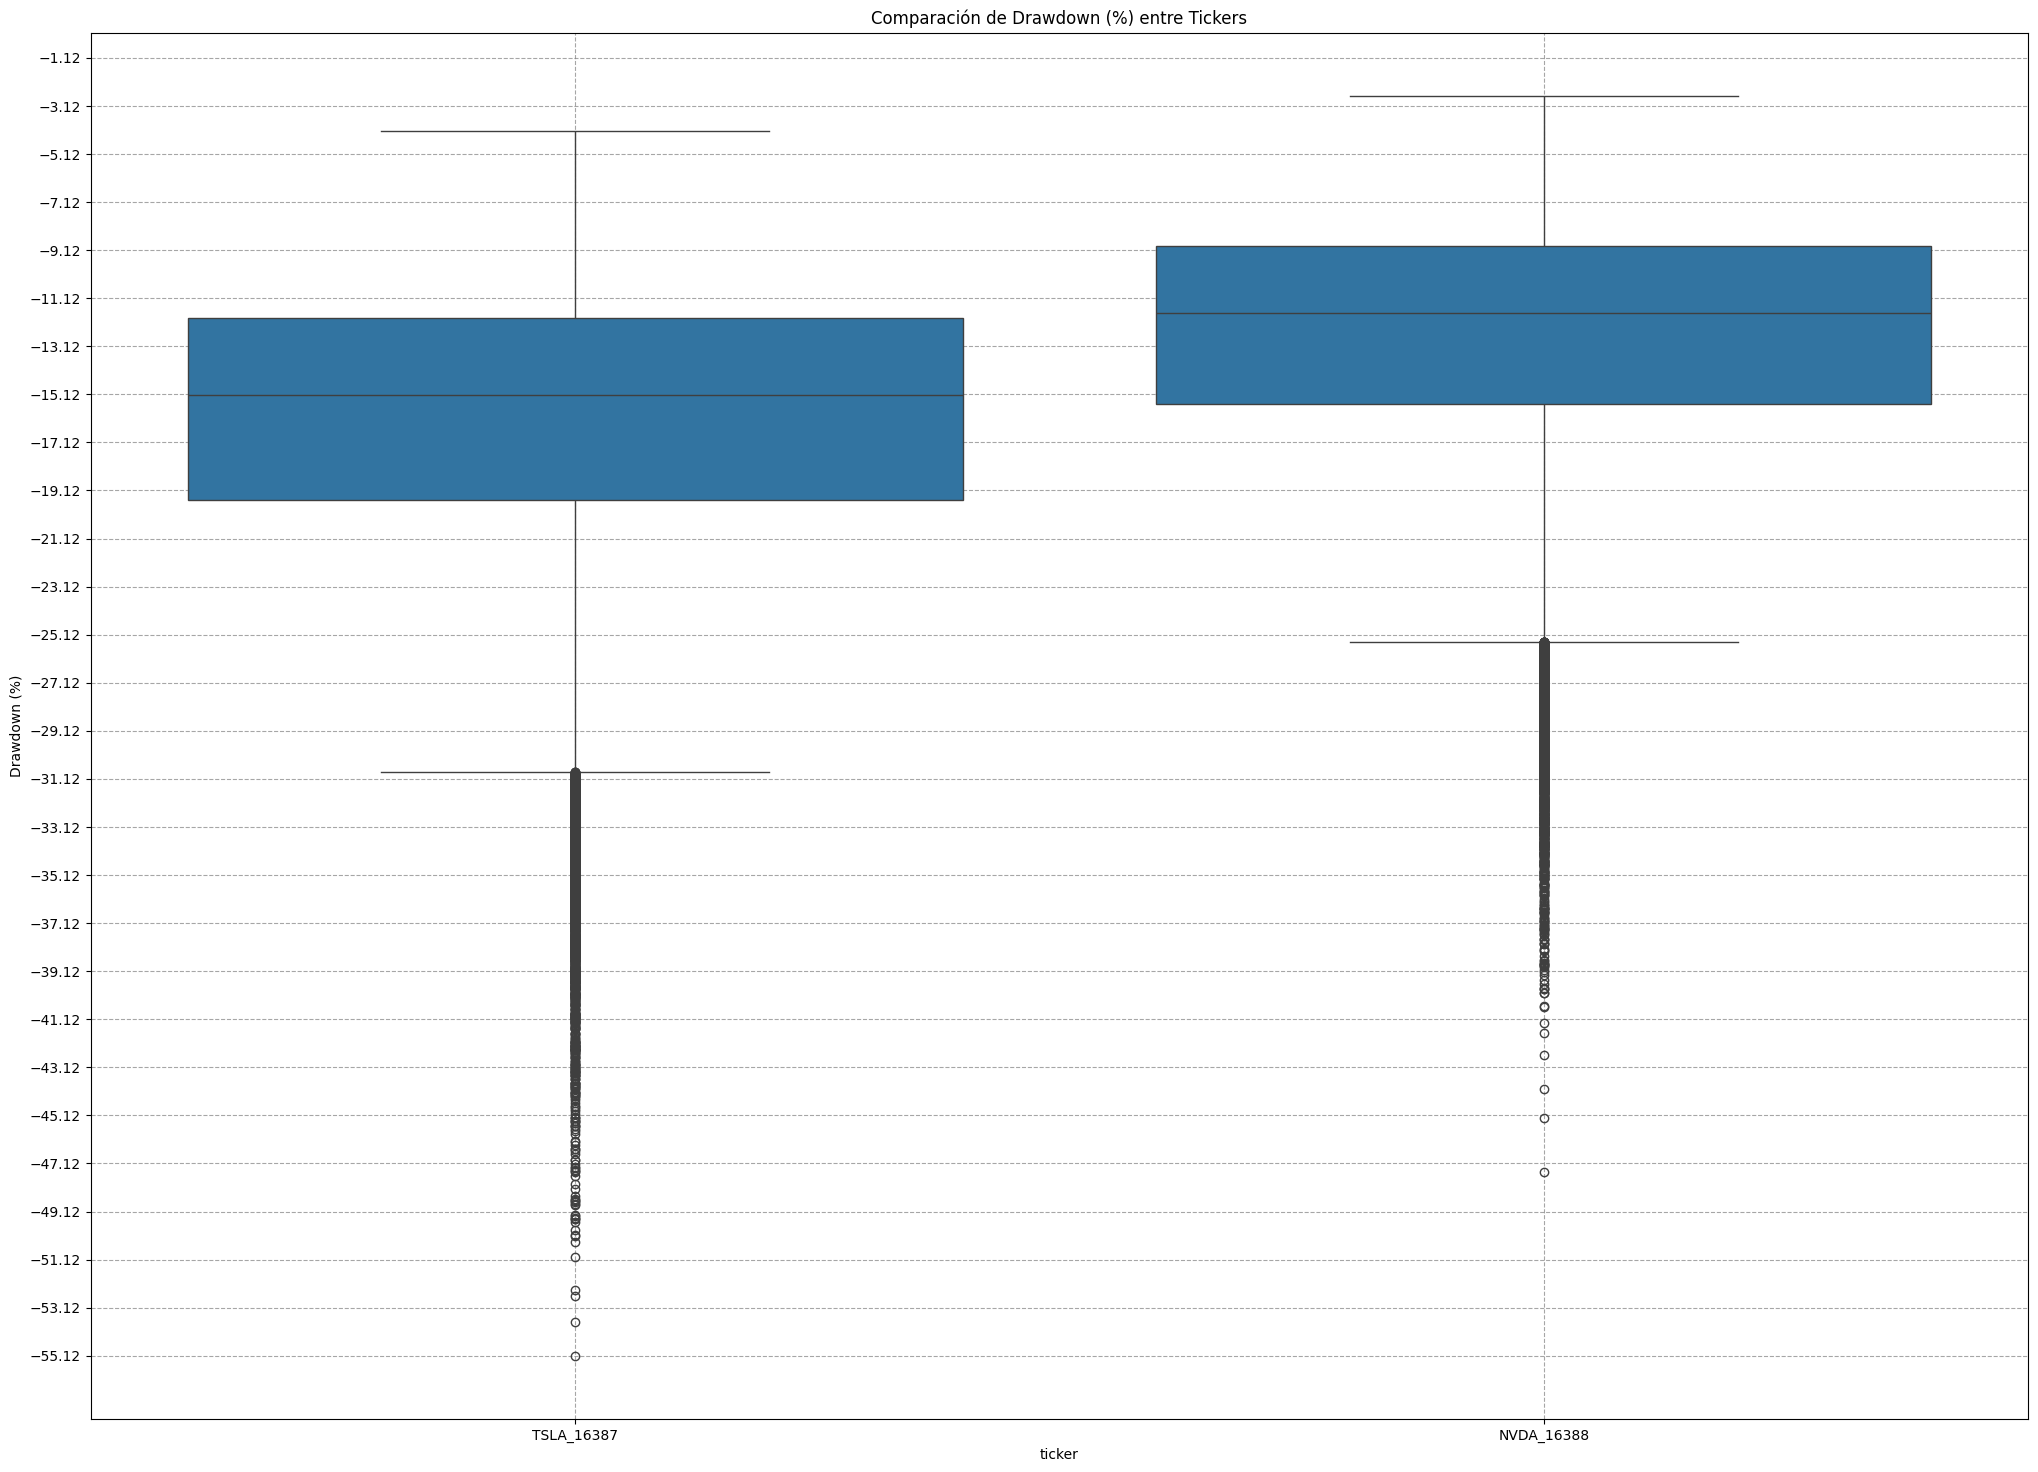

In [39]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_drawdowns, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = all_drawdowns["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = all_drawdowns["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()


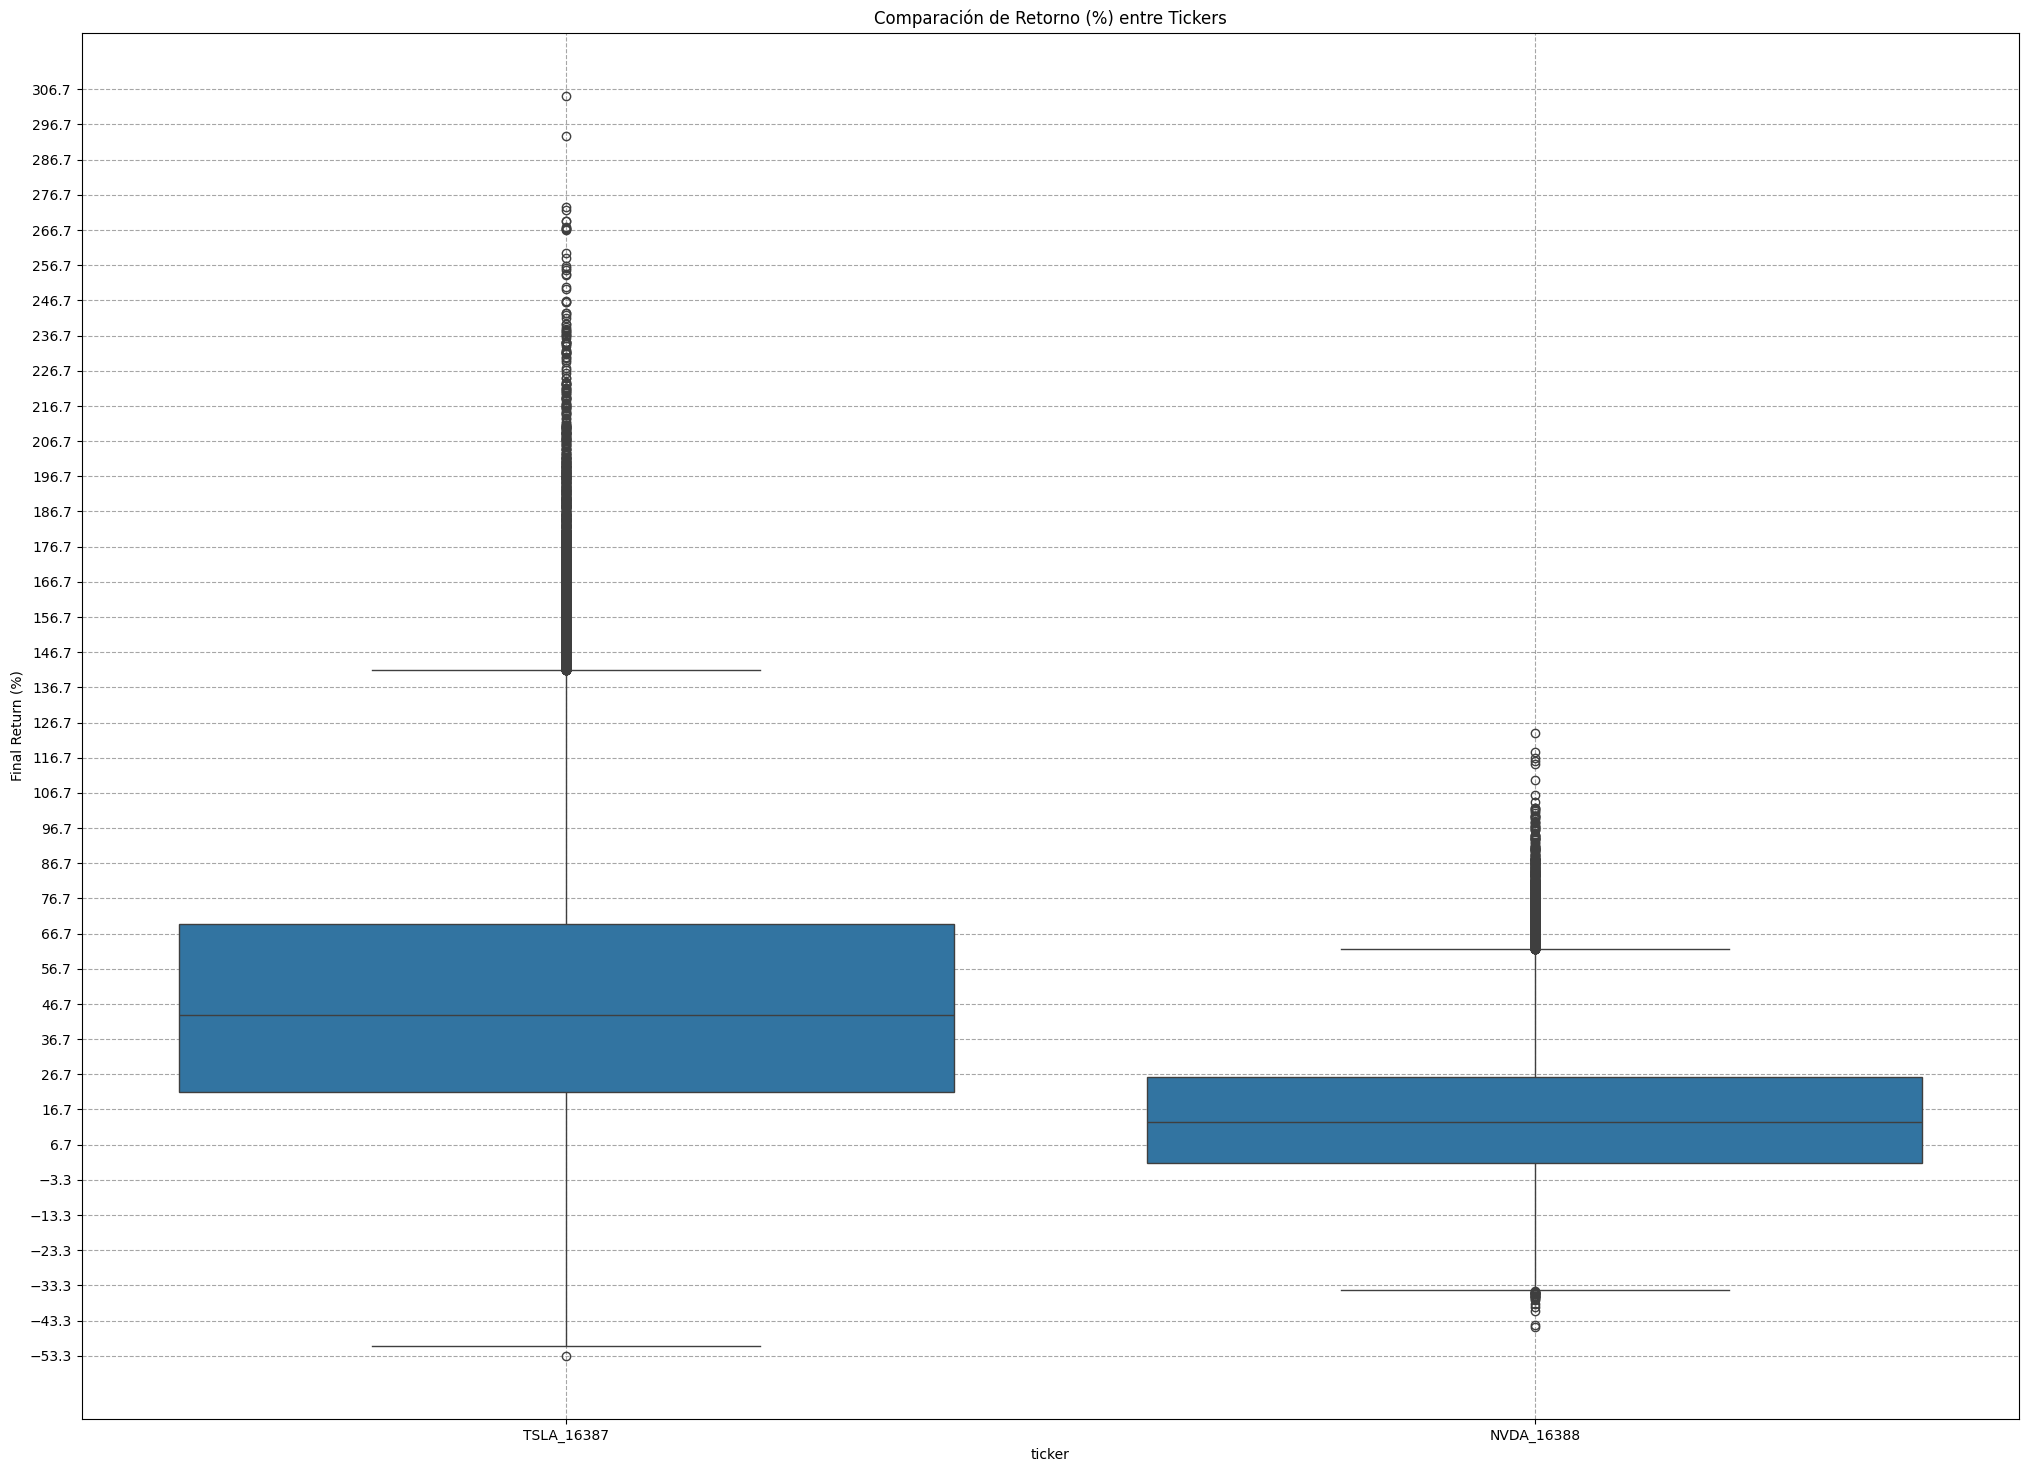

In [40]:
# Generar el gráfico
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_returns, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = all_returns["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = all_returns["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()
